In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')

from matplotlib import font_manager
f_path = '/Library/Fonts/Arial Unicode.ttf'
font_manager.FontProperties(fname=f_path).get_name()
from matplotlib import rc
rc('font', family = 'Arial Unicode MS')

In [302]:
# 데이터 가지고오기
socar_df = pd.read_csv("../../0. raw_data/insurance_fraud_detect_data.csv")
pd.set_option('display.max_columns', len(socar_df.columns))
socar_df.head()

,fraud_YN,car_model,sharing_type,age_group,has_previous_accident,cumulative_use_count,b2b,accident_ratio,pf_type,socarpass,socarsave,start_hour,duration,accident_hour,repair_cost,insure_cost,accident_location,car_part1,car_part2,repair_cnt,acc_type1,insurance_site_aid_YN,police_site_aid_YN,total_prsn_cnt,test_set
0,0,2,1,3,0,2,0,100,2,0,0,4,2,4,1.302547e+05,0,1,0,0,1,0,0,0,-1,0
1,0,1,0,4,0,4,0,0,3,1,0,1,4,4,0.000000e+00,0,1,1,1,2,1,1,1,0,1
2,0,1,0,4,1,4,0,100,3,1,0,1,4,6,2.581306e+05,12925040,3,1,0,2,1,1,1,0,1
3,0,3,1,3,0,4,0,0,2,0,0,3,3,5,1.341009e+06,0,3,1,0,1,0,0,0,-1,0
4,0,1,0,1,0,1,0,100,1,0,0,1,1,1,5.240306e+05,1209410,1,0,0,2,0,0,0,-1,0


In [303]:
# column 확인
socar_df.columns

Index(['fraud_YN', 'car_model', 'sharing_type', 'age_group',
       'has_previous_accident', 'cumulative_use_count', 'b2b',
       'accident_ratio', 'pf_type', 'socarpass', 'socarsave', 'start_hour',
       'duration', 'accident_hour', 'repair_cost', 'insure_cost',
       'accident_location', 'car_part1', 'car_part2', 'repair_cnt',
       'acc_type1', 'insurance_site_aid_YN', 'police_site_aid_YN',
       'total_prsn_cnt', 'test_set'],
      dtype='object')

In [304]:
# test 셋 분리해놓고, test column 삭제
train_df = socar_df[socar_df.test_set == 0]
final_test_df = socar_df[socar_df.test_set == 1]
train_df.drop(['test_set'], axis=1, inplace=True)
final_test_df.drop(['test_set'], axis=1, inplace=True)

In [305]:
train_df.reset_index(drop=True, inplace=True)
final_test_df.reset_index(drop=True, inplace=True)

In [306]:
# 나중에 test 세트를 예측해야 하니까 test 세트도 변수에 넣어줌.
# final 붙은 data는 최종 성능 점검에서만 사용 !
X_final_test = final_test_df.iloc[:, 1:]
y_fianl_test = final_test_df.iloc[:, 0]

In [307]:
# 학습해야 할 train 세트 - 타겟변수와 피쳐 분리
X = train_df.iloc[:, 1:]
y = train_df.iloc[:, 0]

X.shape, y.shape

((12879, 23), (12879,))

In [308]:
# 사기 데이터 비율
def frauds_rate(df):
    fr =round(df["fraud_YN"].value_counts()[1]/len(df)*100,2)
    print("Frauds", fr, "% of the dataset")

In [309]:
# 불균형 데이터
# 최종 성능 점검 셋에만 살짝 부족 .. 성능 좋으면 정말 분류 잘하는 거야
frauds_rate(socar_df)
frauds_rate(train_df)
frauds_rate(final_test_df)

Frauds 0.26 % of the dataset
Frauds 0.26 % of the dataset
Frauds 0.22 % of the dataset


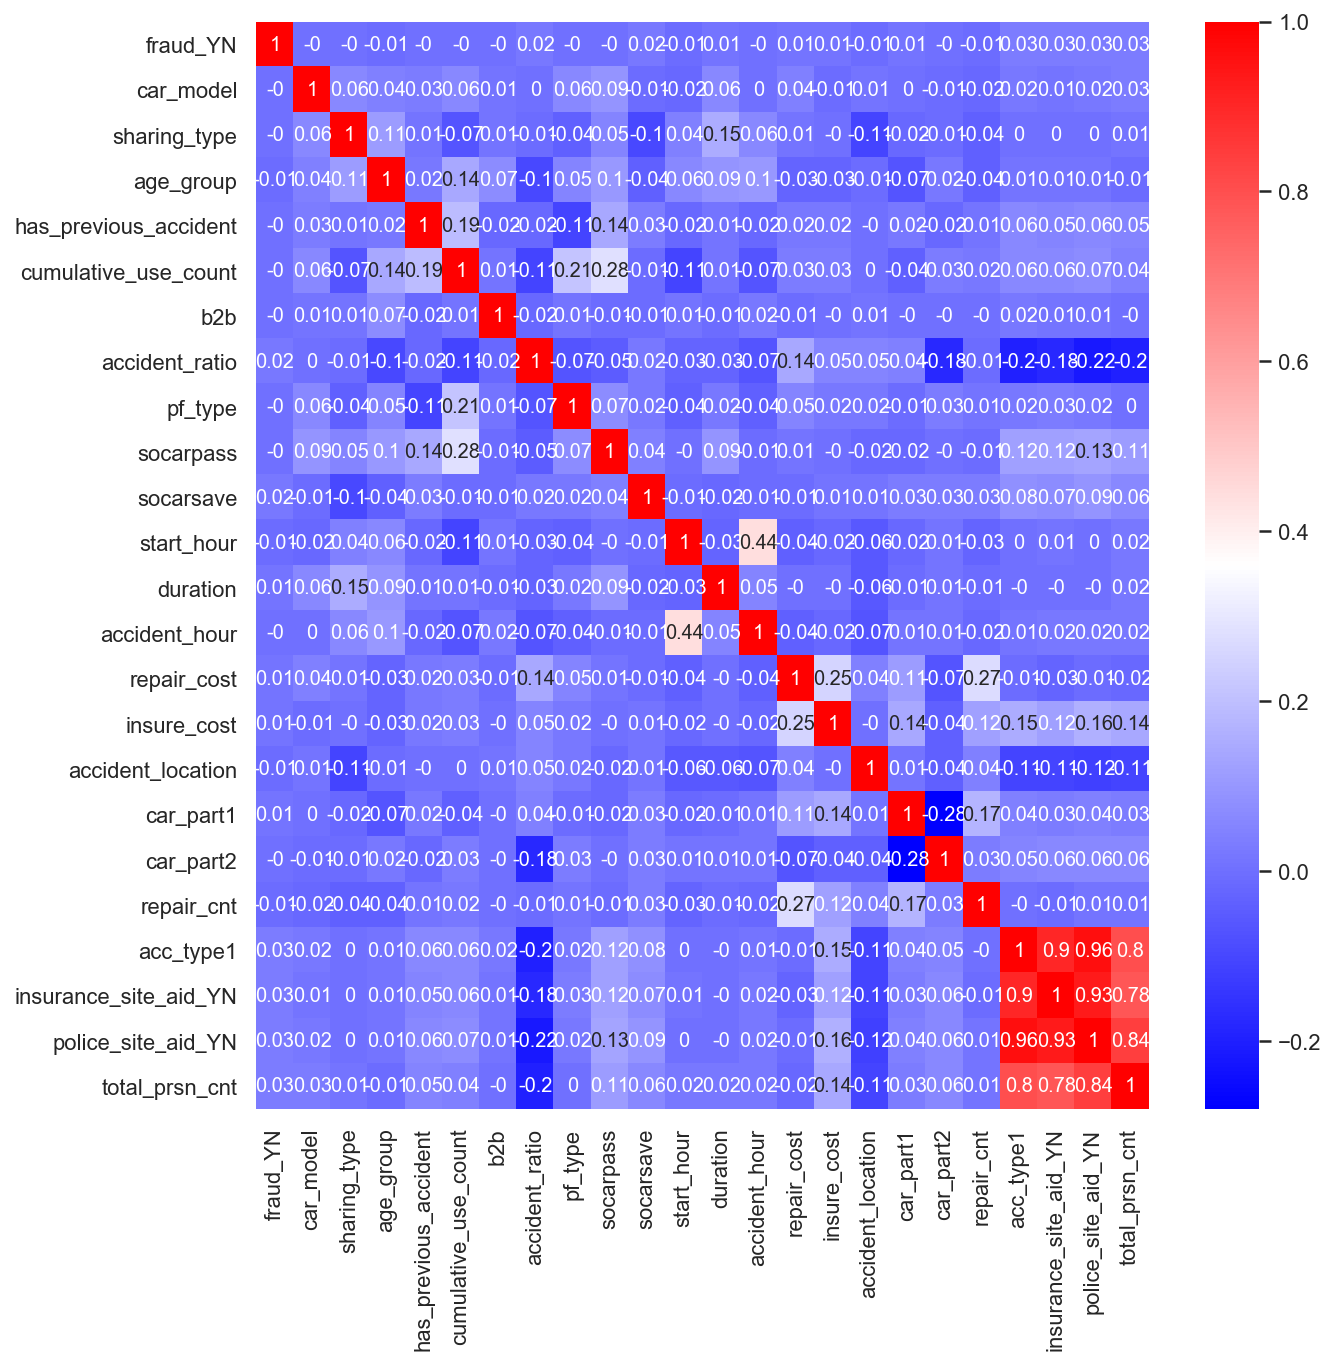

In [310]:
# 변수간 상관관계확인
# acc_type1, insurance_site_aid_YN, police_site_aid_YN, total_prsn_cnt 간에 서로의 상관관계 높음
# 어떻게 scaling 할지 연구
plt.figure(figsize=(10,10))
sns.heatmap(round(train_df.corr(),2), annot=True, cmap='bwr');

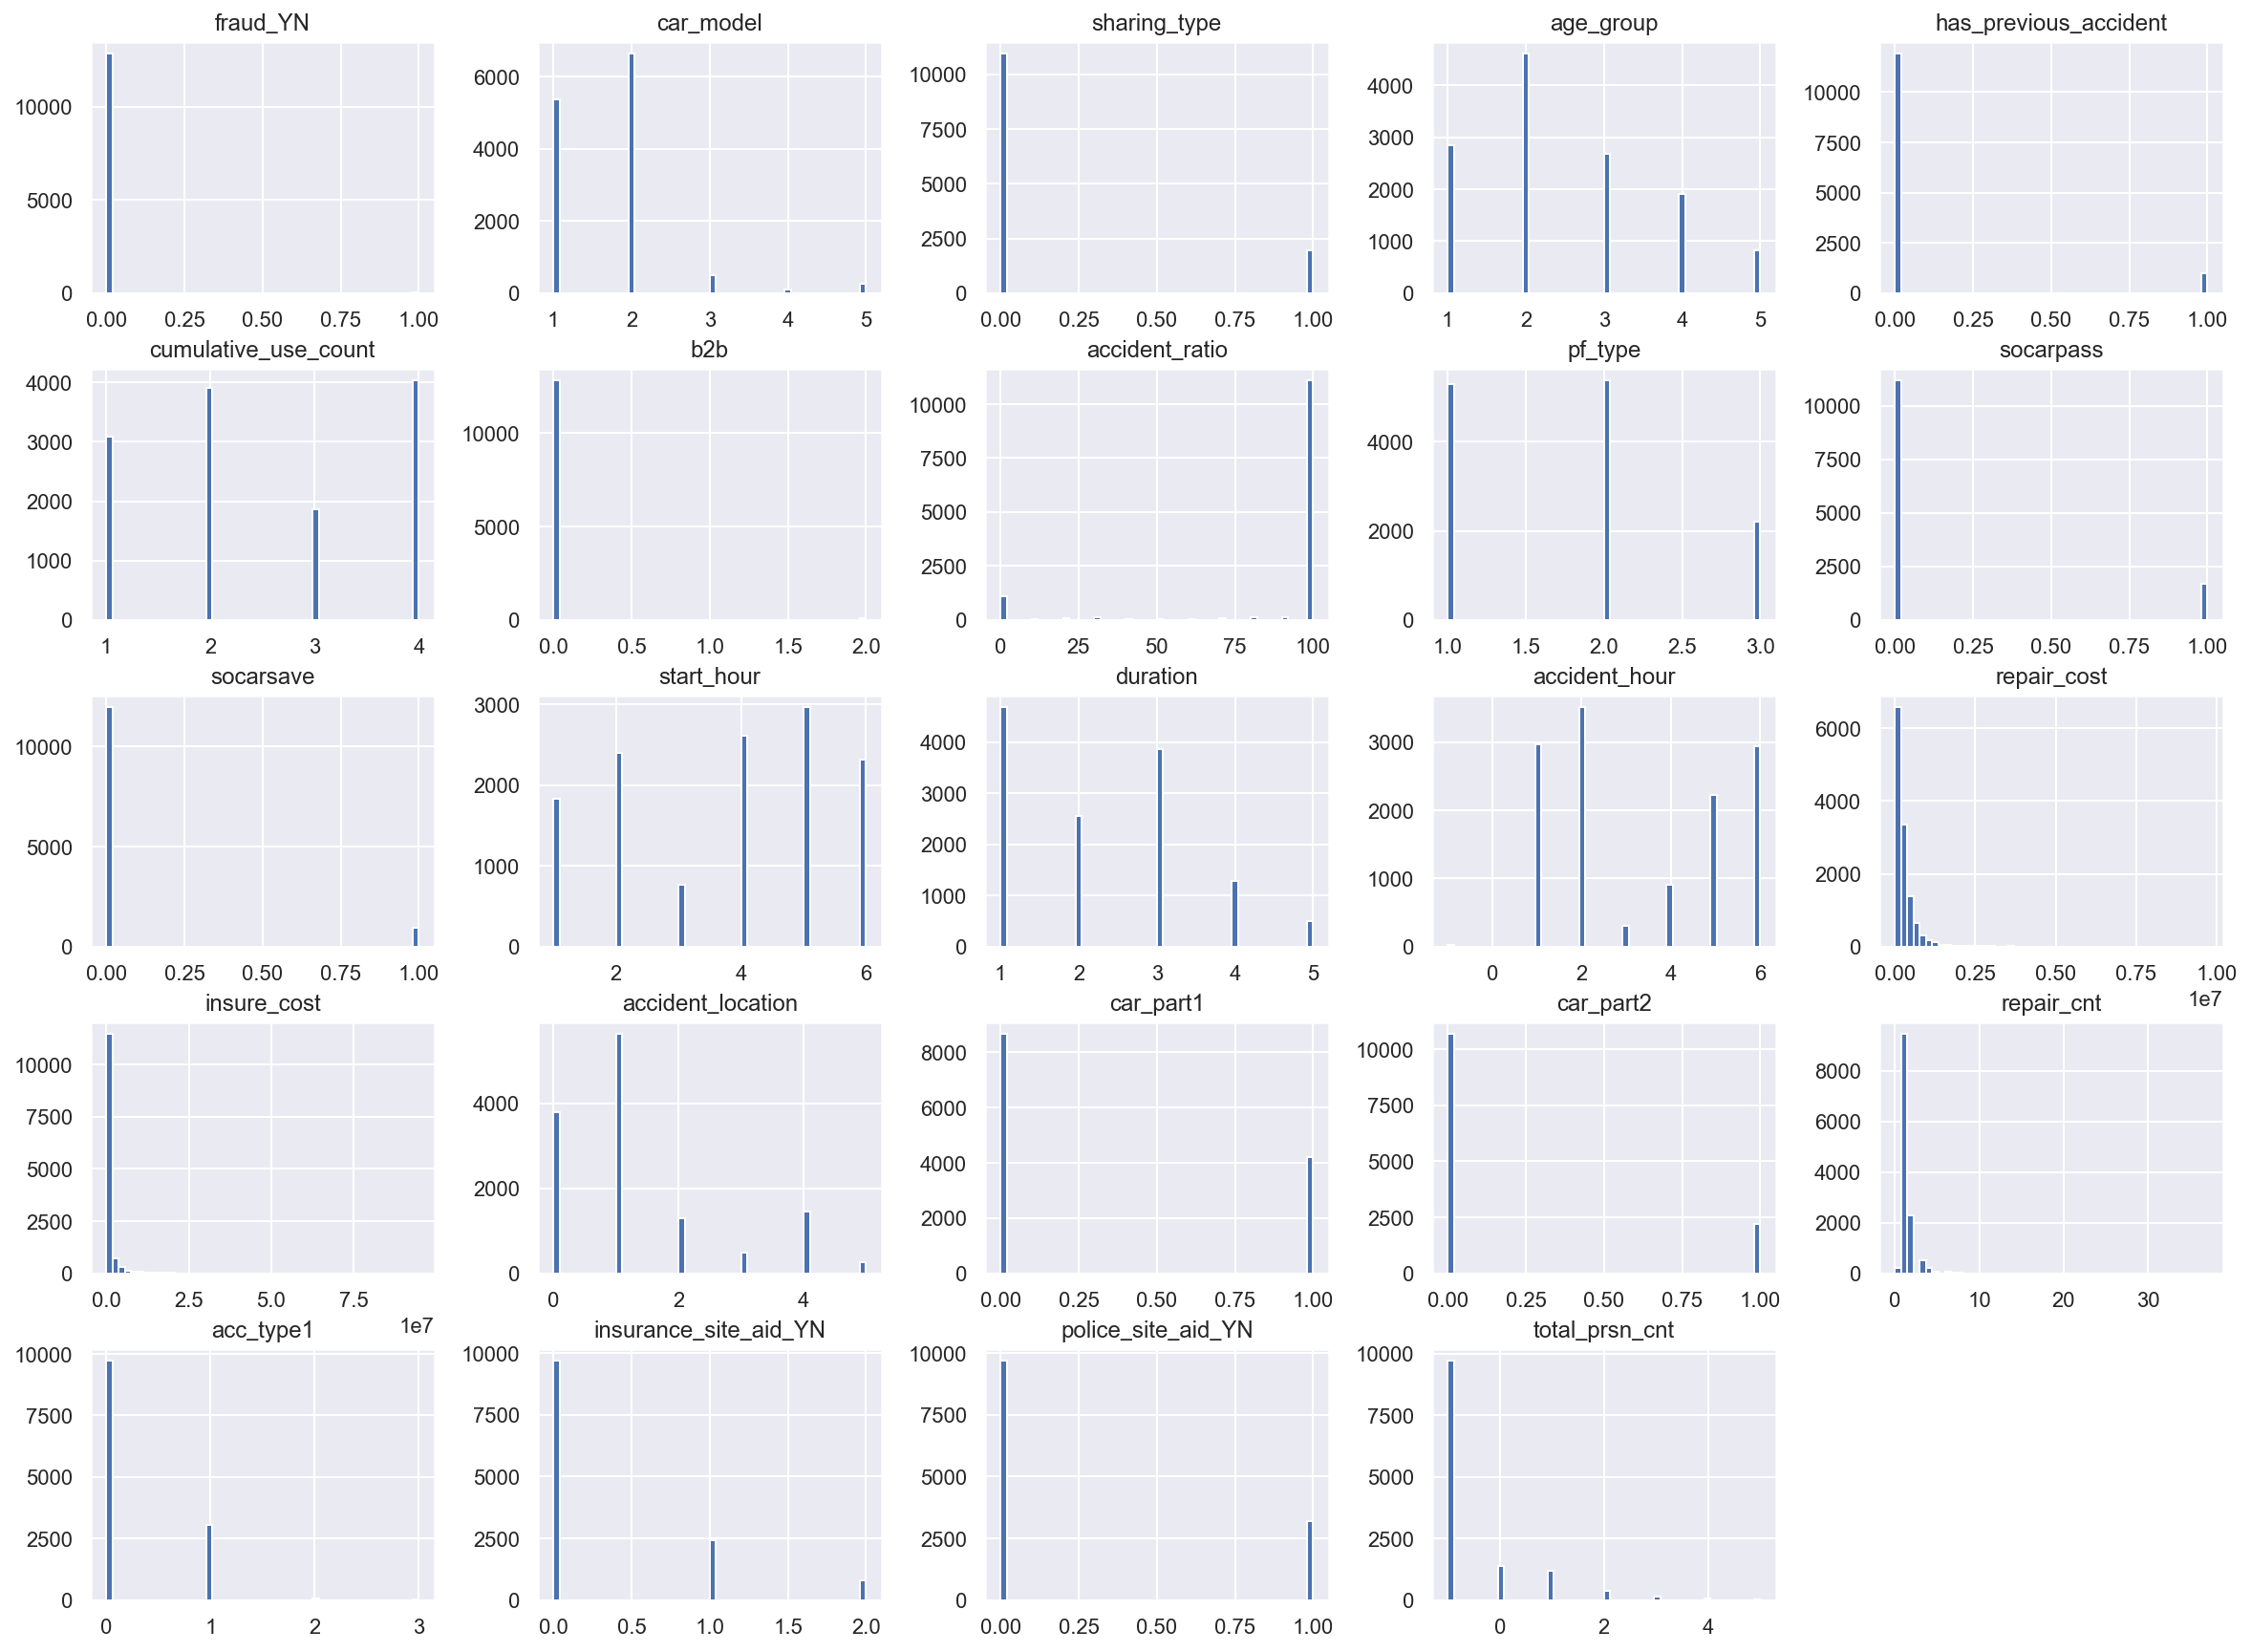

In [311]:
%matplotlib inline
train_df.hist(bins=50, figsize=(20,15));

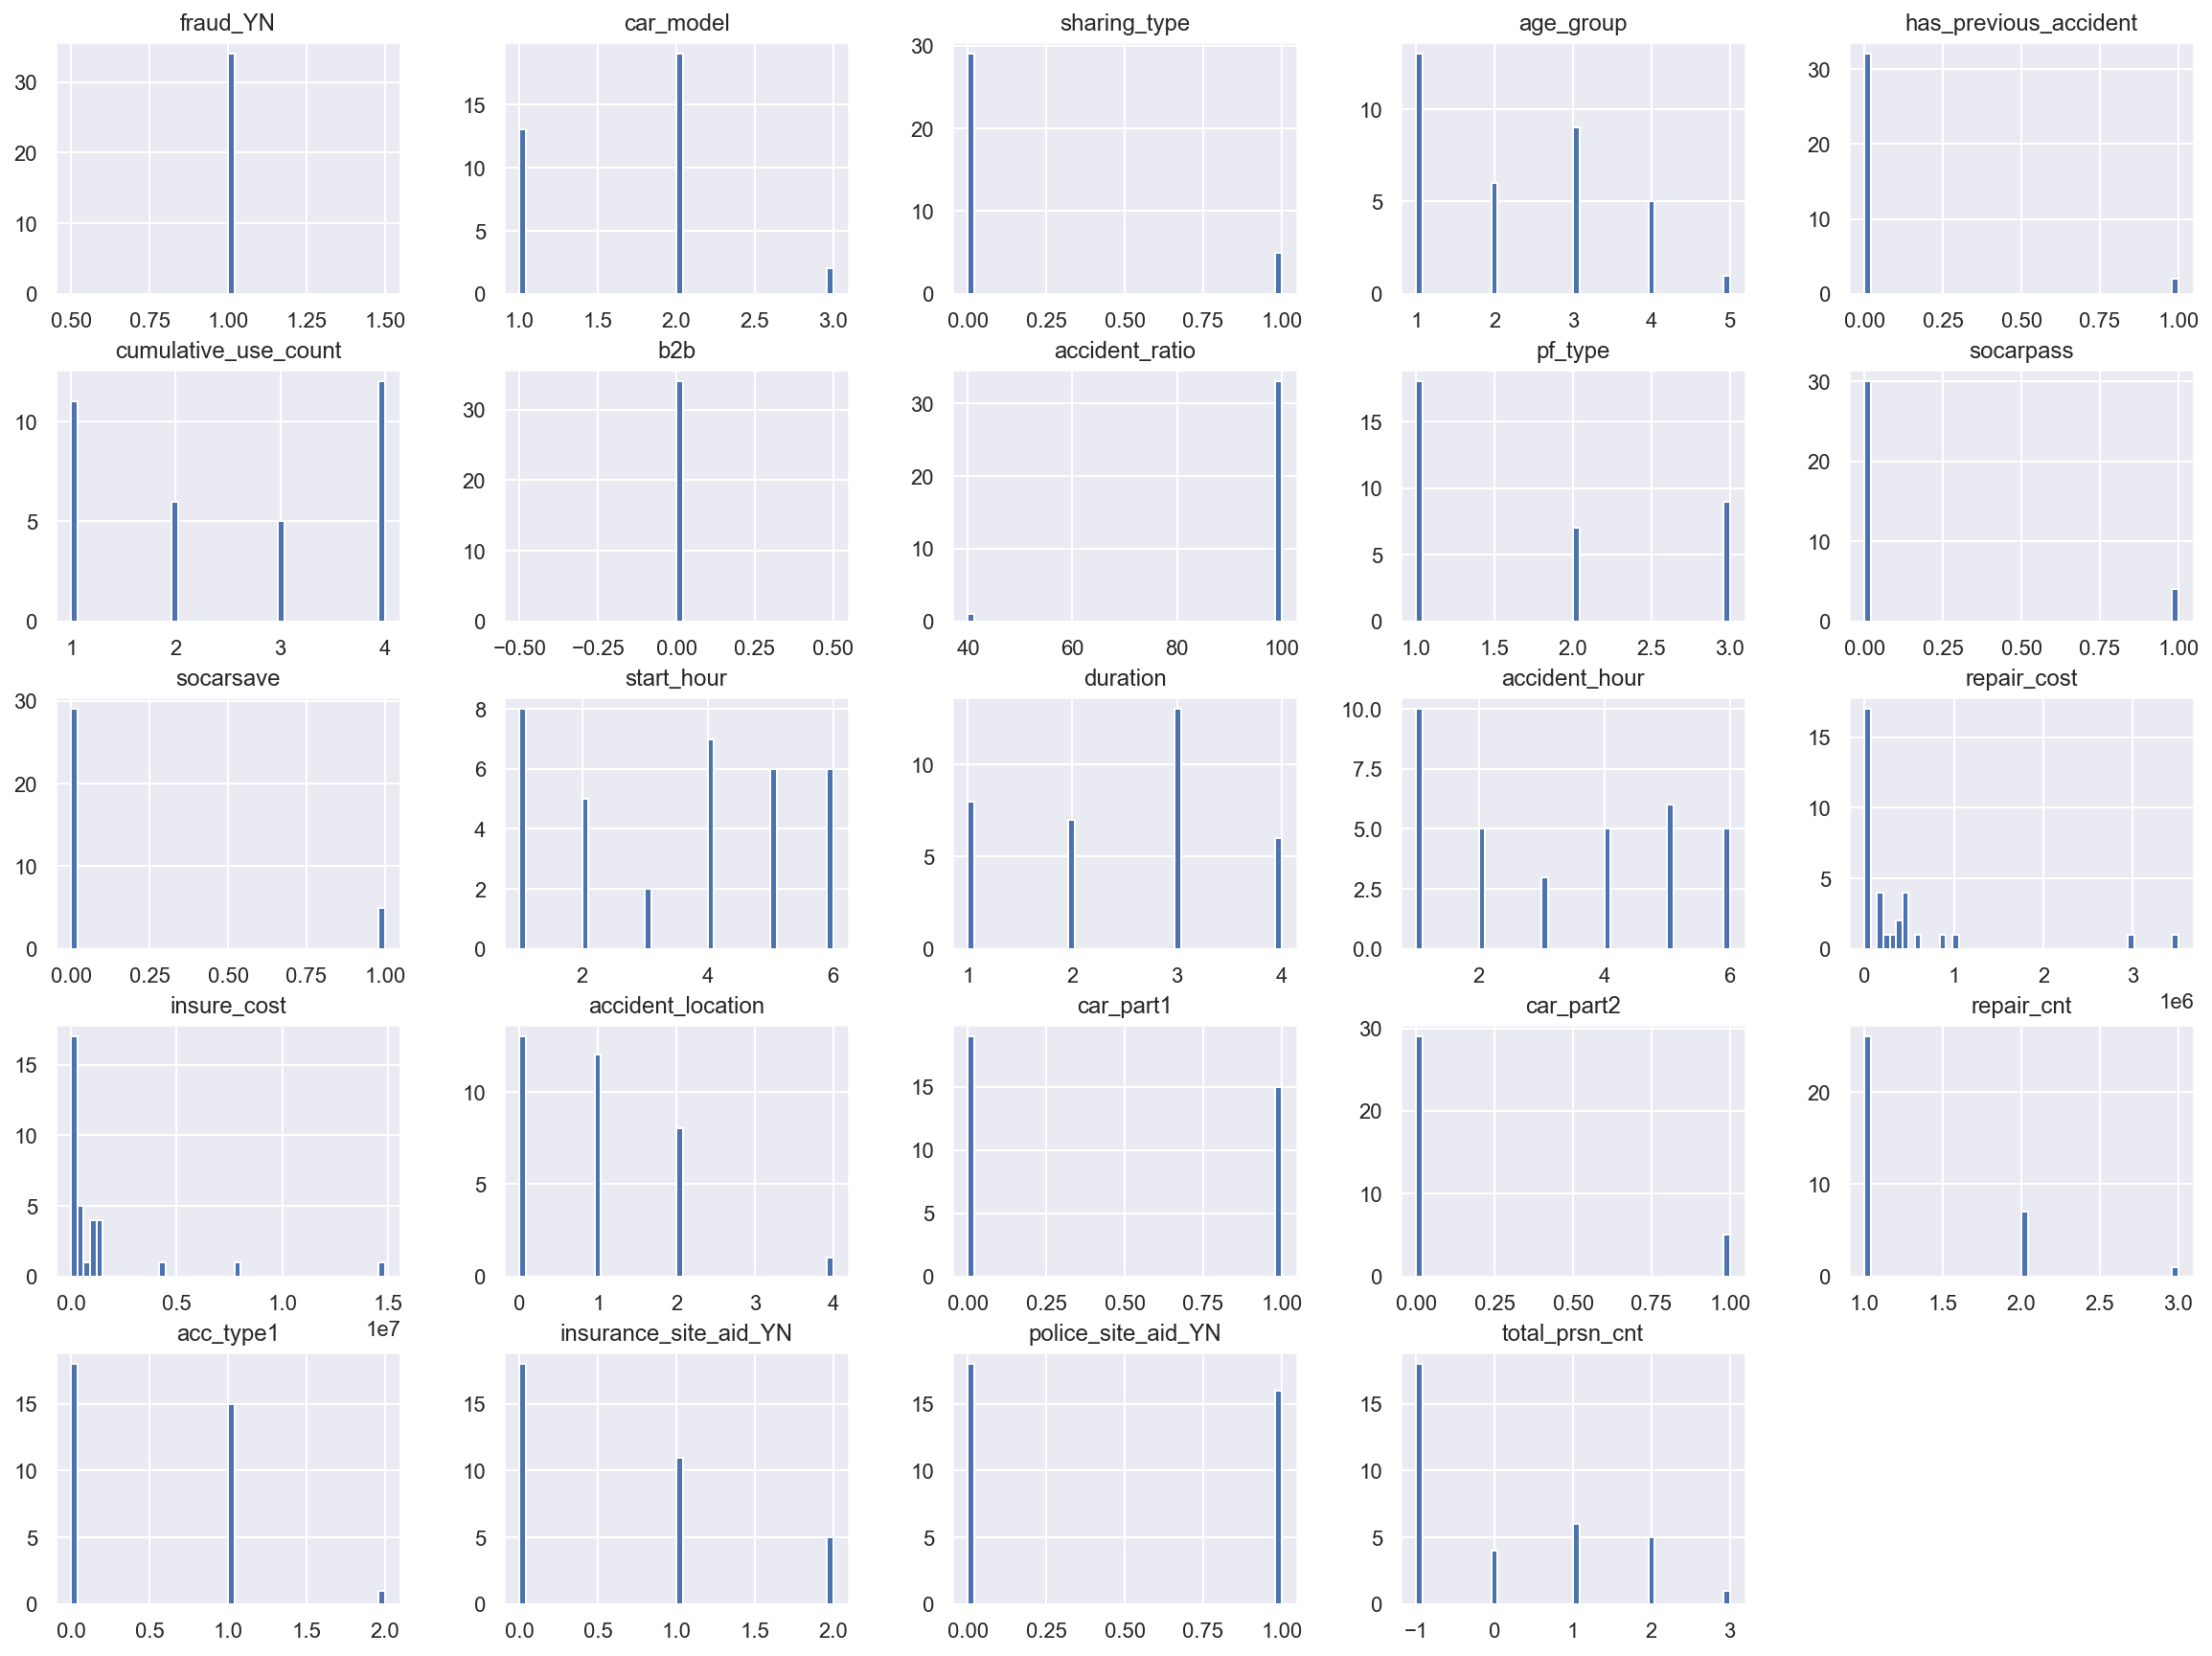

In [312]:
train_df[train_df['fraud_YN']==1].hist(bins=50, figsize=(20,15));

In [313]:
# 전체 train data 와 Frand=1 인 데이터의 분포를 분리해서 비교해보았다. 
# age_count, pf_type, accident_hour 등에서 분포가 매우 다르게 나타난다.
# 이런 것들은 어떻게 해석하고 modeling 하면 좋을까?

### 1. Original Data

In [314]:
# train_set 내에서 train / test(validation) set 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, stratify=y)

In [315]:
import numpy as np

np.unique(y_train, return_counts=True)

(array([0, 1]), array([8991,   24]))

In [316]:
tmp = np.unique(y_train, return_counts=True)[1]
tmp[1]/len(y_train) *100

0.26622296173044924

In [317]:
tmp = np.unique(y_test, return_counts=True)[1]
tmp[1]/len(y_test) *100

0.2587991718426501

In [318]:
# 성능지표 반환 함수 생성
from sklearn.metrics import(accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)

def get_clf_eval(y_test, pred):
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    
    return acc, pre, re, f1, auc

In [319]:
# confusion_matrix 생성함수
from sklearn.metrics import confusion_matrix

def print_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    acc, pre, re, f1, auc = get_clf_eval(y_test, pred)
    
    print('=> confusion matrix')
    print(confusion)
    print('====================')
    
    print('Accuracy: {0:.4f}, Precision: {1:.4f}'.format(acc, pre))
    print('Recall: {0:.4f}, F1: {1:.4f}, AUC: {2:.4f}'.format(re, f1, auc))

### 분류모델 
- 1. Logistic Regression
- 2. Decision Tree
- 3. Random Forest
- 4. LightGBM

In [320]:
# logistic regression
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=13, solver='liblinear')
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

print_clf_eval(y_test, lr_pred)

=> confusion matrix
[[3854    0]
 [  10    0]]
Accuracy: 0.9974, Precision: 0.0000
Recall: 0.0000, F1: 0.0000, AUC: 0.5000


In [321]:
# decision tree
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=13, max_depth=4)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

print_clf_eval(y_test, dt_pred)

=> confusion matrix
[[3854    0]
 [  10    0]]
Accuracy: 0.9974, Precision: 0.0000
Recall: 0.0000, F1: 0.0000, AUC: 0.5000


In [322]:
# random forest
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=13, n_jobs=1, n_estimators=100)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

print_clf_eval(y_test, rf_pred)

=> confusion matrix
[[3854    0]
 [  10    0]]
Accuracy: 0.9974, Precision: 0.0000
Recall: 0.0000, F1: 0.0000, AUC: 0.5000


In [323]:
# lgbm
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=1,
                         boost_from_average=False)
lgbm_clf.fit(X_train, y_train)
lgbm_pred= lgbm_clf.predict(X_test)

print_clf_eval(y_test, lgbm_pred)

=> confusion matrix
[[3853    1]
 [  10    0]]
Accuracy: 0.9972, Precision: 0.0000
Recall: 0.0000, F1: 0.0000, AUC: 0.4999


In [324]:
# 모델과 데이터를 주면 성능을 출력하는 함수 
def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    return get_clf_eval(y_test, pred)

In [325]:
# 다수의 모델 성능을 정리해서 DataFrame으로 반환
def get_result_pd(models, model_names, X_tain, y_train, X_test, y_test):
    col_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    tmp =[]
    
    for model in models:
        tmp.append(get_result(model, X_train, y_train, X_test, y_test))
        
    return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [326]:
# 4개의 분류모델 표로 정리
import time

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

Fit time:  1.6479697227478027


,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.997412,0.0,0.0,0.0,0.50000
DecisionTree,0.997412,0.0,0.0,0.0,0.50000
RandomForest,0.997412,0.0,0.0,0.0,0.50000
LightGBM,0.997153,0.0,0.0,0.0,0.49987


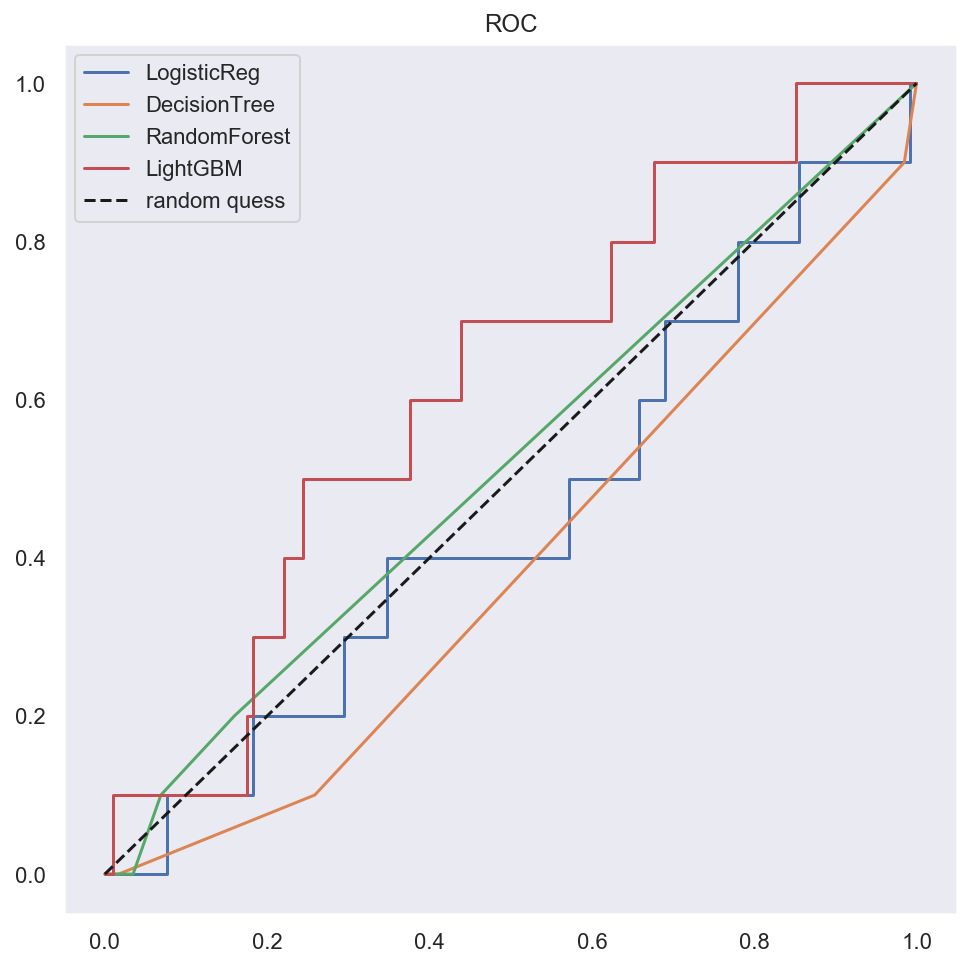

In [327]:
from sklearn.metrics import roc_curve

def draw_roc_curve(model, model_names, X_test, y_test):
    plt.figure(figsize=(8,8))
    
    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label = model_names[model])
        
    plt.plot([0,1], [0,1], 'k--', label = 'random quess')
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

draw_roc_curve(models, model_names, X_test, y_test)   

### 2. StandardScale to sequential features

''

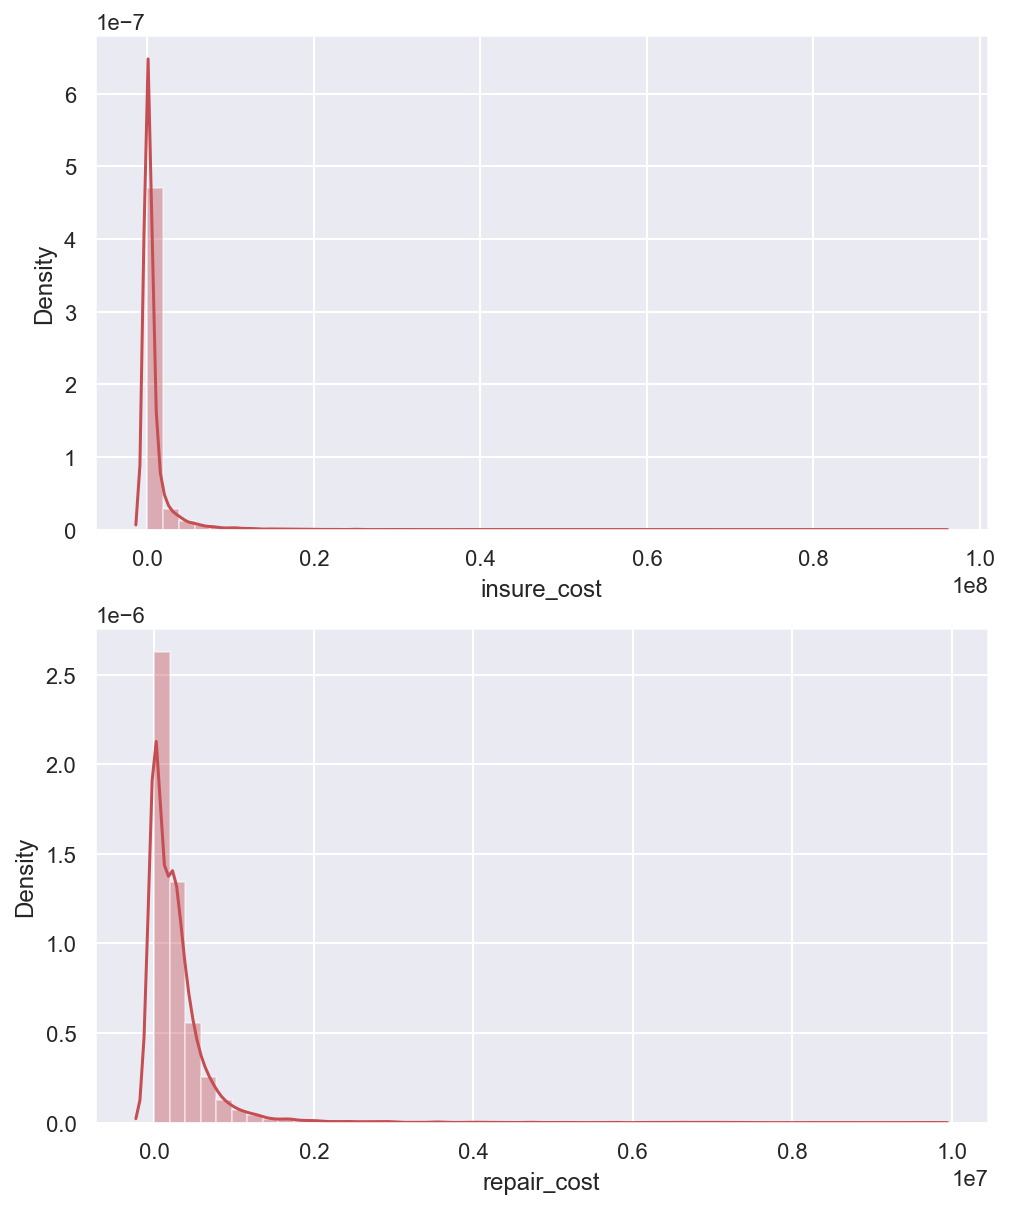

In [328]:
# 연속형 변수는 2개, 분포를 확인해보자
f, ax = plt.subplots(2, 1, figsize = (8, 10))

sns.distplot(train_df["insure_cost"], color="r", ax = ax[0])
sns.distplot(train_df["repair_cost"], color="r", ax = ax[1])
;
# 한쪽으로 매우 치우쳐져있다 -> 표준화

In [329]:
# train_df 에서 연속형 변수 가져와서 scaled feature 만들고
# target feature 및 original 연속형변수 삭제
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
insure_n = scaler.fit_transform(train_df['insure_cost'].values.reshape(-1,1))
repair_n = scaler.fit_transform(train_df['repair_cost'].values.reshape(-1,1))

X_ss = train_df.drop(['fraud_YN', 'insure_cost', 'repair_cost'], axis=1) 
X_ss['scaled_insure_cost'] = insure_n
X_ss['scaled_repair_cost'] = repair_n

X_ss.head()

,car_model,sharing_type,age_group,has_previous_accident,cumulative_use_count,b2b,accident_ratio,pf_type,socarpass,socarsave,start_hour,duration,accident_hour,accident_location,car_part1,car_part2,repair_cnt,acc_type1,insurance_site_aid_YN,police_site_aid_YN,total_prsn_cnt,scaled_insure_cost,scaled_repair_cost
0,2,1,3,0,2,0,100,2,0,0,4,2,4,1,0,0,1,0,0,0,-1,-0.273447,-0.296588
1,3,1,3,0,4,0,0,2,0,0,3,3,5,3,1,0,1,0,0,0,-1,-0.273447,2.047627
2,1,0,1,0,1,0,100,1,0,0,1,1,1,1,0,0,2,0,0,0,-1,0.121310,0.465826
3,1,1,3,0,4,0,100,3,0,0,6,3,1,0,0,0,1,1,2,1,2,0.123879,-0.548781
4,2,0,4,0,4,0,0,1,0,0,4,2,6,1,0,0,1,1,1,1,2,-0.273447,-0.548781


In [330]:
# train_set 내에서 train / test(validation) set 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ss, y, test_size=0.3, random_state=13, stratify=y)

In [331]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

Fit time:  1.5573601722717285


,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.997412,0.0,0.0,0.0,0.50000
DecisionTree,0.997412,0.0,0.0,0.0,0.50000
RandomForest,0.997412,0.0,0.0,0.0,0.50000
LightGBM,0.997153,0.0,0.0,0.0,0.49987


##### * 소름이 끼칠 정도로 original data와 존. 똑.

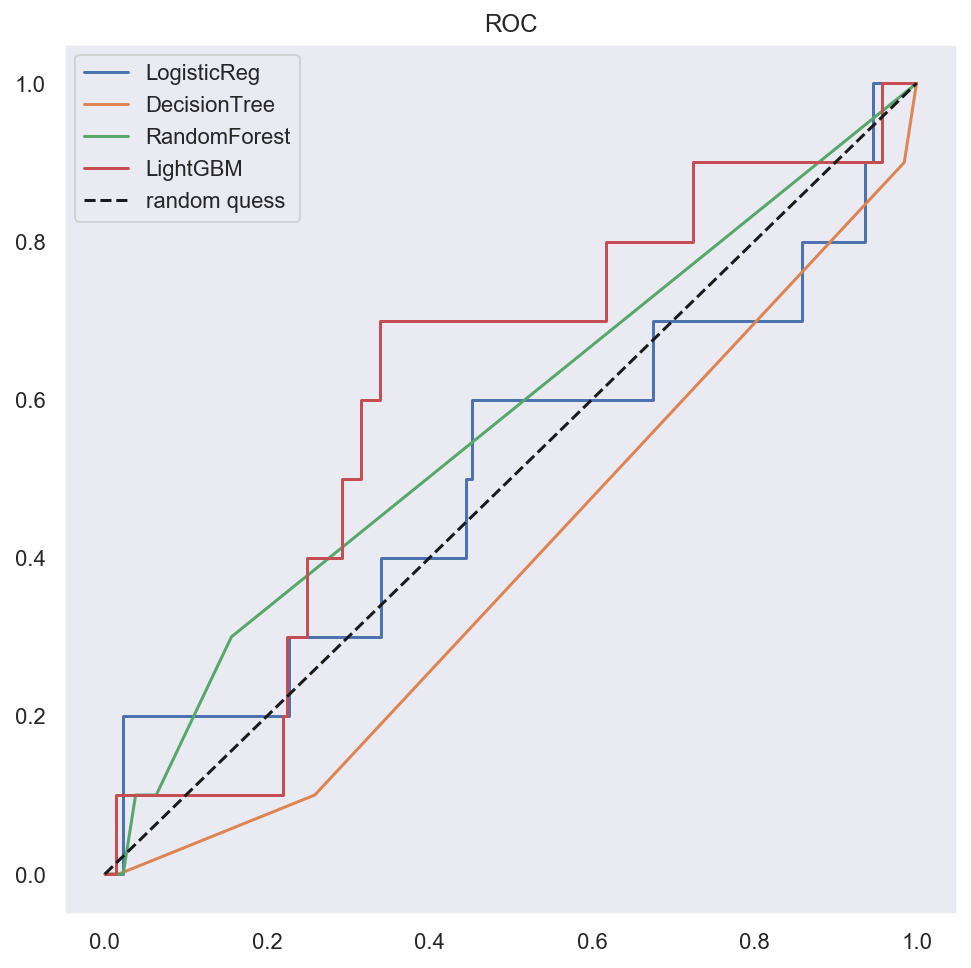

In [332]:
from sklearn.metrics import roc_curve

def draw_roc_curve(model, model_names, X_test, y_test):
    plt.figure(figsize=(8,8))
    
    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label = model_names[model])
        
    plt.plot([0,1], [0,1], 'k--', label = 'random quess')
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

draw_roc_curve(models, model_names, X_test, y_test)   

### 3. log scale

In [333]:
insure_log = np.log1p(train_df['insure_cost'])
repair_log = np.log1p(train_df['repair_cost'])

X_ls= train_df.drop(['insure_cost', 'repair_cost', 'fraud_YN'], axis=1) 
X_ls['scaled_insure_cost'] = insure_log
X_ls['scaled_repair_cost'] = repair_log

X_ls.head()

,car_model,sharing_type,age_group,has_previous_accident,cumulative_use_count,b2b,accident_ratio,pf_type,socarpass,socarsave,start_hour,duration,accident_hour,accident_location,car_part1,car_part2,repair_cnt,acc_type1,insurance_site_aid_YN,police_site_aid_YN,total_prsn_cnt,scaled_insure_cost,scaled_repair_cost
0,2,1,3,0,2,0,100,2,0,0,4,2,4,1,0,0,1,0,0,0,-1,0.000000,11.777255
1,3,1,3,0,4,0,0,2,0,0,3,3,5,3,1,0,1,0,0,0,-1,0.000000,14.108934
2,1,0,1,0,1,0,100,1,0,0,1,1,1,1,0,0,2,0,0,0,-1,14.005644,13.169307
3,1,1,3,0,4,0,100,3,0,0,6,3,1,0,0,0,1,1,2,1,2,14.012130,0.000000
4,2,0,4,0,4,0,0,1,0,0,4,2,6,1,0,0,1,1,1,1,2,0.000000,0.000000


In [334]:
# train_set 내에서 train / test(validation) set 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ls, y, test_size=0.3, random_state=13, stratify=y)

In [335]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

# standard scale과 성능이 똑같아서 roc auc 안그림

Fit time:  1.7271108627319336


,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.997412,0.0,0.0,0.0,0.50000
DecisionTree,0.997412,0.0,0.0,0.0,0.50000
RandomForest,0.997412,0.0,0.0,0.0,0.50000
LightGBM,0.997153,0.0,0.0,0.0,0.49987


### 4. remove outlier

In [336]:
# 사기 데이터라 비용이 fraud가 이상치에서 발생했나 보려고 fraud YN 에 따라 plot 따로 그려봄
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Box(y = train_df[train_df['fraud_YN']==0]['insure_cost'], name = 'insure_cost_0'))
fig.add_trace(go.Box(y = train_df[train_df['fraud_YN']==1]['insure_cost'], name = 'insure_cost_1'))

fig.add_trace(go.Box(y = train_df[train_df['fraud_YN']==0]['repair_cost'], name = 'repair_cost_0'))
fig.add_trace(go.Box(y = train_df[train_df['fraud_YN']==1]['repair_cost'], name = 'repair_cost_1'))

# 이상치가 fraud data에 영향을 끼칠것 같지는 않음

In [337]:
# 이상치 제거하는 함수 생성

def get_outlier(df=None, column=None, weight=1.5):
    fraud= df[df["fraud_YN"]==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_25 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 = quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

In [338]:
# insure_cost에서는 최대치를 벗어나는 값이 3개 있었음
get_outlier(df=train_df, column="insure_cost", weight=1.5)

Int64Index([92, 342, 3773], dtype='int64')

In [339]:
# repair_cost에서는 최대치를 벗어나는 값이 2개 있었음
get_outlier(df=train_df, column="repair_cost", weight=1.5)

Int64Index([12, 4576], dtype='int64')

In [341]:
# 이상치 제거, 중복 index 있으면 unique하게 남겨두기
outlier_index = list(get_outlier(df=train_df, column="insure_cost", weight=1.5)) + list(get_outlier(df=train_df, column="repair_cost", weight=1.5))
outlier_index = set(outlier_index)

# origianl data 이상치 제거 
X_rmol = X.drop(outlier_index, axis=0)

# standard scaled data 이상치 제거 
X_ss_rmol = X_ss.drop(outlier_index, axis=0)

# log scaled data 이상치 제거
X_ls_rmol = X_ls.drop(outlier_index, axis=0)

# target 변수 이상치 제거 
y_rmol = y.drop(outlier_index, axis=0)

In [342]:
X_rmol.shape, X_ss_rmol.shape, X_ls_rmol.shape, y_rmol.shape

((12874, 23), (12874, 23), (12874, 23), (12874,))

In [343]:
# original 이상치 제거
X_train, X_test, y_train, y_test = train_test_split(X_rmol, y_rmol, test_size=0.3, random_state=13, stratify=y_rmol)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

Fit time:  1.4860508441925049


,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.997670,0.0,0.0,0.0,0.50000
DecisionTree,0.997411,0.0,0.0,0.0,0.49987
RandomForest,0.997670,0.0,0.0,0.0,0.50000
LightGBM,0.997670,0.0,0.0,0.0,0.50000


In [344]:
# standard scale 이상치 제거

In [345]:
X_train, X_test, y_train, y_test = train_test_split(X_ss_rmol, y_rmol, test_size=0.3, random_state=13, stratify=y_rmol)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

Fit time:  1.4894390106201172


,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.997670,0.0,0.0,0.0,0.50000
DecisionTree,0.997411,0.0,0.0,0.0,0.49987
RandomForest,0.997670,0.0,0.0,0.0,0.50000
LightGBM,0.997670,0.0,0.0,0.0,0.50000


In [346]:
# log scale 이상치 제거
X_train, X_test, y_test, y_test = train_test_split(X_ls_rmol, y_rmol, test_size=0.3, random_state=13, stratify=y_rmol)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

Fit time:  1.555793046951294


,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.997670,0.0,0.0,0.0,0.50000
DecisionTree,0.997411,0.0,0.0,0.0,0.49987
RandomForest,0.997670,0.0,0.0,0.0,0.50000
LightGBM,0.997670,0.0,0.0,0.0,0.50000


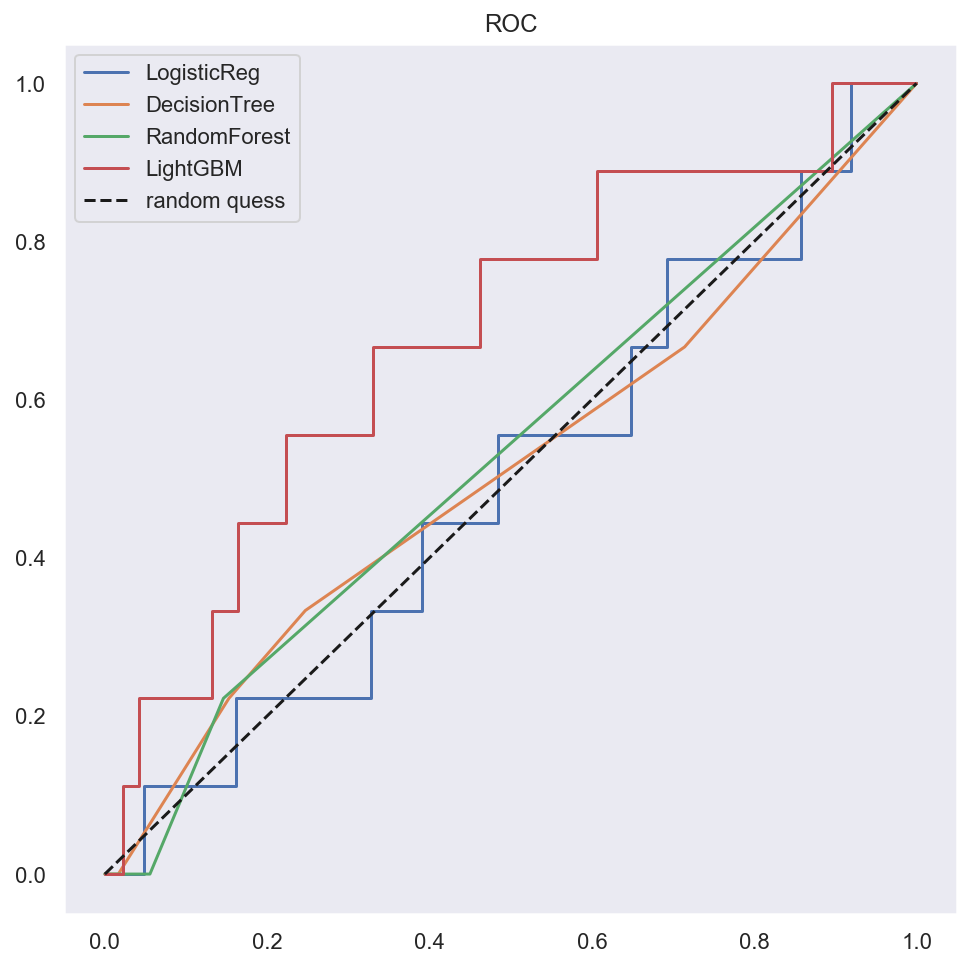

In [347]:
from sklearn.metrics import roc_curve

def draw_roc_curve(model, model_names, X_test, y_test):
    plt.figure(figsize=(8,8))
    
    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label = model_names[model])
        
    plt.plot([0,1], [0,1], 'k--', label = 'random quess')
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

draw_roc_curve(models, model_names, X_test, y_test)   

### 5. Over sampling

In [380]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

In [381]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

In [382]:
X_train_over.shape, y_train_over.shape

((17986, 23), (17986,))

In [383]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_train_over, return_counts=True))

(array([0, 1]), array([8993,   22]))
(array([0, 1]), array([8993, 8993]))


In [384]:
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)
results

,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.996894,0.0,0.0,0.0,0.50000
DecisionTree,0.996636,0.0,0.0,0.0,0.49987
RandomForest,0.996894,0.0,0.0,0.0,0.50000
LightGBM,0.996894,0.0,0.0,0.0,0.50000


# 결론: 연속형 변수의 스케일링 문제는 아닌걸로 . . 